## Importing Packages:

In [8]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Prepare data:

In [10]:
df = pd.read_csv('NEPSE_1yr.csv')

df

,Symbol,Date,Open,High,Low,Close,Percent Change,Volume
0,NEPSE,2021-12-29,2520.55,2538.78,2512.41,2524.50,0.22,3.623480e+09
1,NEPSE,2021-12-28,2523.87,2533.63,2486.05,2518.99,-0.11,3.125576e+09
2,NEPSE,2021-12-27,2600.21,2616.27,2518.16,2521.65,-2.69,5.607440e+09
3,NEPSE,2021-12-26,2531.43,2596.43,2531.15,2591.42,2.82,5.173201e+09
4,NEPSE,2021-12-23,2522.51,2542.29,2485.38,2520.23,0.50,4.490266e+09
...,...,...,...,...,...,...,...,...
4567,NEPSE,2001-09-17,273.01,273.01,273.01,273.01,0.00,0.000000e+00
4568,NEPSE,2001-09-14,265.22,265.22,265.22,265.22,0.00,0.000000e+00
4569,NEPSE,2001-09-13,261.37,261.37,261.37,261.37,0.00,0.000000e+00
4570,NEPSE,2001-09-12,269.17,269.17,269.17,269.17,0.00,0.000000e+00


### Plotting the target variable:

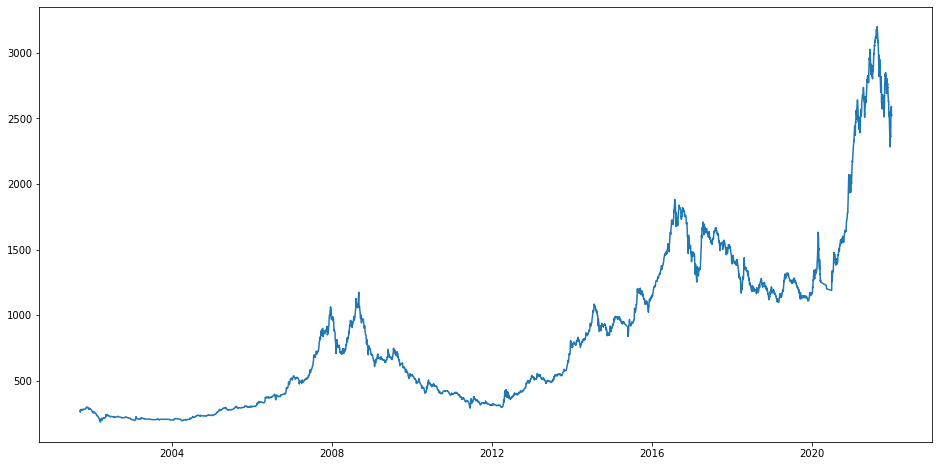

In [3]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [4]:
# #creating dataframe with date and the target variable
# data = df.sort_index(ascending=True, axis=0)
# new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

In [5]:
# for i in range(0,len(data)):
#      new_data['Date'][i] = data['Date'][i]
#      new_data['Close'][i] = data['Close'][i]

In [12]:
# train = new_data[:4000]
# valid = new_data[4000:]

# print('\n Shape of training set:')
# print(train.shape)

# print('\n Shape of validation set:')
# print(valid.shape)


 Shape of training set:
(4000, 2)

 Shape of validation set:
(572, 2)


## Using LSTM:

### Setting up data:

In [13]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [14]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [15]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [17]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:3800,:]
valid = dataset[3800:,:]

In [18]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [19]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


## Creating the LSTM model:

In [23]:
# create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50))
# model.add(Dense(1))

regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

### Fitting the model:

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)


Epoch 1/10


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_13428]

Function call stack:
train_function -> train_function -> train_function


In [25]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_14344]

Function call stack:
predict_function -> predict_function -> predict_function


### Result Demo:

In [26]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

NameError: name 'closing_price' is not defined

### Visualizing the plot:

In [ ]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])